In [ ]:
from diff_weighted_fields import Grid1D, PowerSpectrum, GaussianFieldGenerator1D, Zeldovich1D
import jax
import jax.numpy as jnp
from jax.random import PRNGKey, split
import matplotlib.pyplot as plt
from tqdm import tqdm
 
L       = 4000
N       = 1024
dk      = 10     # units of kf
kmin    = 2      # units of kf
R_clip  = 2      # units of cell size
kmax    = 0.5    # units of kNyq

grid = Grid1D((N,),    L, R_clip=R_clip, dk=dk, kmax=kmax, kmin=kmin)
mesh = Grid1D((N//2,), L, R_clip=R_clip, dk=dk, kmax=kmax, kmin=kmin)

In [2]:
def PK(k, theta, threshold=0.001):
    A, R, n = theta
    _p = A * (k * R)**n * jnp.exp(-(k * R)**2)
    sig = jnp.max(_p)
    return _p + sig * threshold

In [5]:
# Build these only once—​they will be "closed over" by our JIT’d functions below.
gen  = GaussianFieldGenerator1D(grid, PK)
zel0 = Zeldovich1D(gen, mesh, scheme='cic')

In [6]:
N_real = 300
keys = split(PRNGKey(2), N_real)
noise = jnp.stack([grid.generate_hermitian_noise(k) for k in keys])  # shape (300, N)

In [8]:
@jax.jit
def _plin_mark(D, theta, R_smooth, C, noise_i):
    zel = jax.tree_util.tree_map(lambda x: x, zel0)
    zel = zel.make_realization(D, theta, noise_i)
    zel.compute_fft()
    zel.ComputeBasis(R_smooth)
    f = zel.WeightedChild(C)
    return PowerSpectrum(f, f)

@jax.jit
def plin_mark(theta, D, R_smooth, C):
    """
    Returns the mean power‐spectrum (shape P_len) of 300 noise realizations,
    each drawn through _plin_mark_jit. 
    This is now a single JIT’d kernel that vmap‐fuses those 300 calls.
    """
    return jnp.mean(
        jax.vmap(lambda ε: _plin_mark(D, theta, R_smooth, C, ε), in_axes=0)(noise),
        axis=0
    )


In [9]:
D = 1.0

#params
A = 2.0
R = 2*grid.H[0]
n = 2.0
theta = jnp.array([A,R,n])

R_smooth = 0.
C = jnp.array([1,0,0,0])

In [17]:
def cov_fast(ps_all):
    mean_ps  = jnp.mean(ps_all, axis=0)                # (P_len,)
    demeaned = ps_all - mean_ps[None, :]               # (N_real, P_len)
    return (demeaned.T @ demeaned) / (ps_all.shape[0] - 1.0)  # (P_len, P_len)


@jax.jit
def cov_mark(theta, D, R_smooth, C):
    # Reuse the same vmap approach as plin_mark, but keep all P_len outputs:
    ps_all = jax.vmap(lambda ε: _plin_mark(D, theta, R_smooth, C, ε), in_axes=0)(noise)
    return cov_fast(ps_all)

In [24]:
jac_plin_mark = jax.jit(jax.jacfwd(plin_mark, argnums=0))

@jax.jit
def ParamCov_marked(theta, D, R_smooth, C):
    """
    θ = (A,R,n), returns the 3×3 parameter covariance :
      [Jᵀ Σ⁻¹ J]⁻¹
    """
    # (a) Compute J: shape (P_len, 3)
    J = jac_plin_mark(theta, D, R_smooth, C)

    # (b) Compute full covariance Σ of shape (P_len, P_len)
    Σ = cov_mark(theta, D, R_smooth, C)  # (P_len, P_len)

    # (c) Instead of Σ_inv = inv(Σ), do solve Σ X = J  → X has shape (P_len, 3)
    X = jnp.linalg.solve(Σ, J)

    # (d) Build the small (3×3) Fisher = Jᵀ X
    M = J.T @ X  # shape (3, 3)

    # (e) Return its inverse
    return jnp.linalg.inv(M)  # (3, 3)

@jax.jit
def FoM_marked(theta, D, R_smooth, C):
    """
    Returns det(ParamCov_marked) for parameters θ given mark vector C.
    """
    cov3 = ParamCov_marked(theta, D, R_smooth, C)  # (3,3)
    return jnp.linalg.det(cov3)                    # scalar

In [50]:
@jax.jit
def FoM_marked_C_vec(theta, D, R_smooth, C_flat):
    # C_flat: shape (nC, 4)
    return jax.vmap(lambda c: FoM_marked(theta, D, R_smooth, c), in_axes=0)(C_flat)
    # → returns shape (nC,)

In [57]:
A = 2.0
R = 4 * grid.H[0]
n = 2.0
theta = jnp.array([A, R, n])

D = 1.0
R_smooth = 2.0 * mesh.H

Nx, Ny = 200, 200
x_min, x_max = -2.0, 2.0
y_min, y_max = -2.0, 2.0

x_vec = jnp.linspace(x_min, x_max, Nx)
y_vec = jnp.linspace(y_min, y_max, Ny)
X, Y  = jnp.meshgrid(x_vec, y_vec, indexing='xy')
xs_flat = X.ravel()  # (40 000,)
ys_flat = Y.ravel()

ones_flat = jnp.ones_like(xs_flat)
zeros_flat = jnp.zeros_like(xs_flat)
C_flat = jnp.stack([ones_flat/5, xs_flat, ys_flat, zeros_flat], axis=1)  # shape (40 000, 4)


# ─────── 2) Warm up / compile on a small batch ───────

BATCH_COMPILE = 500
_ = FoM_marked_C_vec(theta, D, R_smooth, C_flat[:BATCH_COMPILE]).block_until_ready()


# ─────── 3) Evaluate FoM in chunks and collect results ───────

batch_size = BATCH_COMPILE
n_total = C_flat.shape[0]
results = []

In [ ]:
for start in tqdm(range(0, n_total, batch_size)):
    end = min(start + batch_size, n_total)
    chunk = C_flat[start:end]
    fom_chunk = FoM_marked_C_vec(theta, D, R_smooth, chunk).block_until_ready()
    results.append(jnp.array(fom_chunk))  # convert to NumPy

In [60]:
# Concatenate into a single 1D NumPy array of length 40 000
fom_all = jnp.concatenate(results, axis=0)


# ─────── 4) Reshape into (Ny, Nx) and plot ───────

fom_grid = fom_all.reshape(Ny, Nx)


In [19]:
from diff_weighted_fields import Grid1D, PowerSpectrum, GaussianFieldGenerator1D, Zeldovich1D
import jax
import jax.numpy as jnp
from jax.random import PRNGKey, split
import matplotlib.pyplot as plt
from tqdm import tqdm
 
L       = 4000
N       = 1024
dk      = 10     # units of kf
kmin    = 2      # units of kf
R_clip  = 0      # units of cell size
kmax    = 1    # units of kNyq

grid = Grid1D((N,),    L, R_clip=R_clip, dk=dk, kmax=kmax, kmin=kmin)
mesh = Grid1D((N//2,), L, R_clip=R_clip, dk=dk, kmax=kmax, kmin=kmin)

def PK(k, theta, threshold=0.001):
    A, R, n = theta
    _p = A * (k * R)**n * jnp.exp(-(k * R)**2)
    sig = jnp.max(_p)
    return _p + sig * threshold

gen  = GaussianFieldGenerator1D(grid, PK)
zel0 = Zeldovich1D(gen, mesh, scheme='cic')

kmin: 0.0031415926535897933
kmax: 0.8042477369308472
dk: 0.015707963267948967
kmin: 0.0031415926535897933
kmax: 0.4021238684654236
dk: 0.015707963267948967


In [40]:
D = 0.1
A = 2.0 
R = 2*grid.H[0] 
n = 2.0
theta = jnp.array([A, R, n])
N_real = 300
keys = split(PRNGKey(2), N_real)
noise = jnp.stack([grid.generate_hermitian_noise(k) for k in keys])  # shape (300, N)
C = jnp.array([1,0,0,0])

In [41]:
def compute_base_fields(D: float, theta: jnp.ndarray, noise_batch: jnp.ndarray, R_smooth: float):
    def one_real(noise_i):
        zel = Zeldovich1D(gen, mesh, scheme='cic')
        zel = zel.make_realization(D, theta, noise_i)
        zel.compute_fft()
        zel.ComputeBasis(R_smooth)
        return zel.one_plus_delta, zel.m_array
    
    return jax.vmap(one_real, in_axes=0)(noise_batch)

def ps_all_for_C(base_one_plus: jnp.ndarray,
                 base_m_array: jnp.ndarray,C: jnp.ndarray):
    
    # 1) Build weighted field: m_all[r,x] = sum_i C[i] * base_m_array[r,i,x]
    m_all = jnp.einsum('i,r i n->r n', C, base_m_array)  # (N_real, N)

    # 2) Weighted density: rho_w[r,x] = m_all[r,x] * base_one_plus[r,x]
    rho_w = m_all * base_one_plus                         # (N_real, N)

    # 3) Normalize to δ_marked[r,x] = rho_w[r,x]/mean_x[rho_w[r,*]] − 1
    mean_rho = jnp.mean(rho_w, axis=1, keepdims=True)     # (N_real, 1)
    delta_marked = rho_w / mean_rho - 1.0                  # (N_real, N)

    # 4) Batched FFT (use grid.norm_fft)
    delta_k_marked = jnp.fft.fft(delta_marked, axis=-1) * grid.norm_fft  # (N_real, N)
    
    # 5) Bin each row into P_len bins
    P_len = grid.k_ctrs.shape[0]
    def ps_one(delta_k_row):
        field_flat = (delta_k_row * jnp.conjugate(delta_k_row))
        kmap = jnp.where(mesh.k_mapping >= 0, mesh.k_mapping, 0)
        valid = (mesh.k_mapping >= 0)
        flat_vals = jnp.where(valid, field_flat.reshape(-1), 0.0)
        counts = jnp.bincount(kmap.reshape(-1),
                              weights=valid.astype(flat_vals.dtype).reshape(-1),
                              length=P_len)
        power = jnp.bincount(kmap.reshape(-1),
                             weights=flat_vals,
                             length=P_len)
        pk = jnp.real(jnp.where(counts > 0, power / counts, 0.0))
        return pk * (mesh.H**mesh.Ndim)  # (P_len,)

    return jax.vmap(ps_one, in_axes=0)(delta_k_marked)

def ps_mean_for_C(base_one_plus: jnp.ndarray,
                  base_m_array: jnp.ndarray,
                  C: jnp.ndarray):
    ps_all = ps_all_for_C(base_one_plus, base_m_array, C)  # (N_real, P_len)
    return jnp.mean(ps_all, axis=0) 

In [42]:
base_one_plus, m = compute_base_fields(D,theta, noise, R_smooth=0.0)

In [43]:
ps_mean_for_C(base_one_plus, m, C).block_until_ready()

Array([7.7333068e-05, 3.8934289e-04, 9.1257435e-04, 1.5848974e-03,
       2.2575422e-03, 2.7151620e-03, 2.8788408e-03, 3.1052968e-03,
       3.0345218e-03, 2.6879217e-03, 2.2778525e-03, 1.8912185e-03,
       1.4938836e-03, 1.1789621e-03, 8.6391857e-04, 6.3247565e-04,
       4.3998403e-04, 3.3498215e-04, 2.6101989e-04, 2.0697061e-04,
       1.5897474e-04, 1.3524963e-04, 1.1670709e-04, 1.0238724e-04,
       9.6988457e-05, 9.4279763e-05, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32)

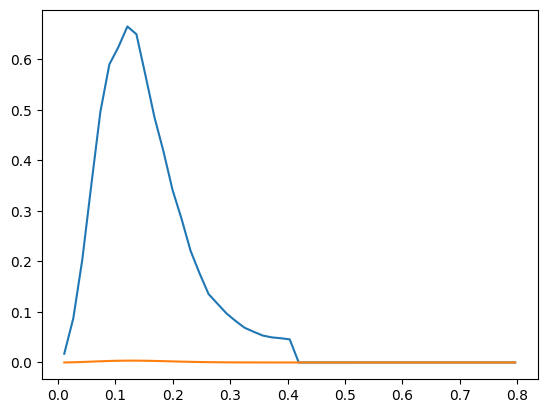

In [45]:
plt.plot(grid.k_ctrs,jnp.mean(t,axis = 0))
plt.plot(grid.k_ctrs,PK(grid.k_ctrs, theta)*D**2/2, label='PK')